# Classifier
- Author: Baptiste PILLOY

## Process data and perform quick EDA

1: Cooler condition / %:
- 3: close to total failure
- 20: reduced effifiency
- 100: full efficiency

2: Valve condition / %:
- 100: optimal switching behavior
- 90: small lag
- 80: severe lag
- 73: close to total failure

3: Internal pump leakage:
- 0: no leakage
- 1: weak leakage
- 2: severe leakage

4: Hydraulic accumulator / bar:
- 130: optimal pressure
- 115: slightly reduced pressure
- 100: severely reduced pressure
- 90: close to total failure

5: stable flag:
- 0: conditions were stable
- 1: static conditions might not have been reached yet

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_curve, roc_curve, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [70]:
# Define constants
PROFILE_COLUMN_NAMES = ['cooler_condition', 'valve_condition', 'pump_leakage', 'accumulator_pressure', 'stable_flag']
COOLER_CONDITION_MAP = {3: 0.0, 20: 0.5, 100: 1.0}
VALVE_CONDITION_MAP = {100: 1.0, 90: 0.75, 80: 0.5, 73: 0.25}
PUMP_LEAKAGE_MAP = {2: 0.0, 1: 0.5, 0: 1.0}
ACCUMULATOR_PRESSURE_MAP = {130: 1.0, 115: 0.75, 100: 0.5, 90: 0.25}
STABLE_FLAG_MAP = {0: 1.0, 1: 0.0}

def process_data(profile_path, fs1_path, ps2_path):
    # Load data
    profile = pd.read_csv(profile_path, sep='\t', header=None)
    fs1 = pd.read_csv(fs1_path, sep='\t', header=None)
    ps2 = pd.read_csv(ps2_path, sep='\t', header=None)
    
    # Add column names to profile data
    profile.columns = PROFILE_COLUMN_NAMES
    
    # Normalize profile data
    profile['cooler_condition_normalized'] = profile['cooler_condition'].map(COOLER_CONDITION_MAP)
    profile['valve_condition_normalized'] = profile['valve_condition'].map(VALVE_CONDITION_MAP)
    profile['pump_leakage_normalized'] = profile['pump_leakage'].map(PUMP_LEAKAGE_MAP)
    profile['accumulator_pressure_normalized'] = profile['accumulator_pressure'].map(ACCUMULATOR_PRESSURE_MAP)
    profile['stable_flag_normalized'] = profile['stable_flag'].map(STABLE_FLAG_MAP)
    
    profile_normalized = profile[['cooler_condition_normalized', 'valve_condition_normalized', 
                                  'pump_leakage_normalized', 'accumulator_pressure_normalized', 
                                  'stable_flag_normalized']]
    
    # Normalize fs1 data
    fs1_normalized = (fs1 - fs1.min()) / (fs1.max() - fs1.min())
    
    # Normalize ps2 data
    ps2_normalized = (ps2 - ps2.min()) / (ps2.max() - ps2.min())
    
    # Concatenate all data
    data = pd.concat([ps2_normalized, fs1_normalized, profile_normalized], axis=1)
    
    return data, fs1, ps2

# Example usage
profile_path = 'data_subset/profile.txt'
fs1_path = 'data_subset/fs1.txt'
ps2_path = 'data_subset/ps2.txt'

data, fs1, ps2 = process_data(profile_path, fs1_path, ps2_path)
data.columns = data.columns.astype(str)

In [67]:
data

,0,1,2,3,4,5,6,7,8,9,...,595,596,597,598,599,cooler_condition_normalized,valve_condition_normalized,pump_leakage_normalized,accumulator_pressure_normalized,stable_flag_normalized
0,0.128406,0.126233,0.139026,0.135629,0.183728,0.926963,0.851924,0.710694,0.525688,0.503085,...,0.963122,0.983760,0.970271,0.951107,0.992680,0.0,1.0,1.0,1.00,0.0
1,0.118814,0.119439,0.132375,0.128401,0.179034,0.925531,0.847719,0.802688,0.626115,0.599737,...,0.952217,0.984622,0.983628,0.983463,0.971724,0.0,1.0,1.0,1.00,0.0
2,0.120340,0.123603,0.135379,0.129464,0.181270,0.928753,0.877821,0.762099,0.577799,0.528001,...,0.955517,0.986490,0.969841,0.974116,0.980623,0.0,1.0,1.0,1.00,0.0
3,0.115980,0.116809,0.128728,0.122449,0.173670,0.916222,0.851703,0.740890,0.612823,0.592660,...,0.990099,0.977436,0.979176,0.971096,0.954930,0.0,1.0,1.0,1.00,0.0
4,0.111402,0.111988,0.123150,0.120323,0.173000,0.911210,0.873283,0.789389,0.683976,0.663255,...,0.986081,0.965795,0.971133,0.973540,0.962394,0.0,1.0,1.0,1.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.127752,0.131492,0.145462,0.142219,0.203621,0.987827,0.957614,0.903795,0.767708,0.711449,...,0.989095,0.970250,0.947724,0.989215,0.969427,1.0,1.0,1.0,0.25,1.0
2201,0.135601,0.133027,0.143102,0.144133,0.208985,0.991407,0.965803,0.915891,0.784219,0.749145,...,0.970010,0.938344,0.987075,0.974116,0.956940,1.0,1.0,1.0,0.25,1.0
2202,0.126444,0.128424,0.143961,0.143070,0.204068,0.983889,0.959052,0.893389,0.722059,0.660038,...,0.977185,0.956022,0.985495,0.968507,0.942299,1.0,1.0,1.0,0.25,1.0
2203,0.137345,0.133684,0.143102,0.143070,0.207197,0.990691,0.964586,0.935194,0.863812,0.845796,...,0.984359,0.974418,0.953325,0.973253,0.957801,1.0,1.0,1.0,0.25,1.0


Descriptive Statistics for fs1 (Row Means):
count    2205.000000
mean        0.089119
std         0.054251
min         0.010881
25%         0.047236
50%         0.076661
75%         0.115270
max         0.405950
dtype: float64


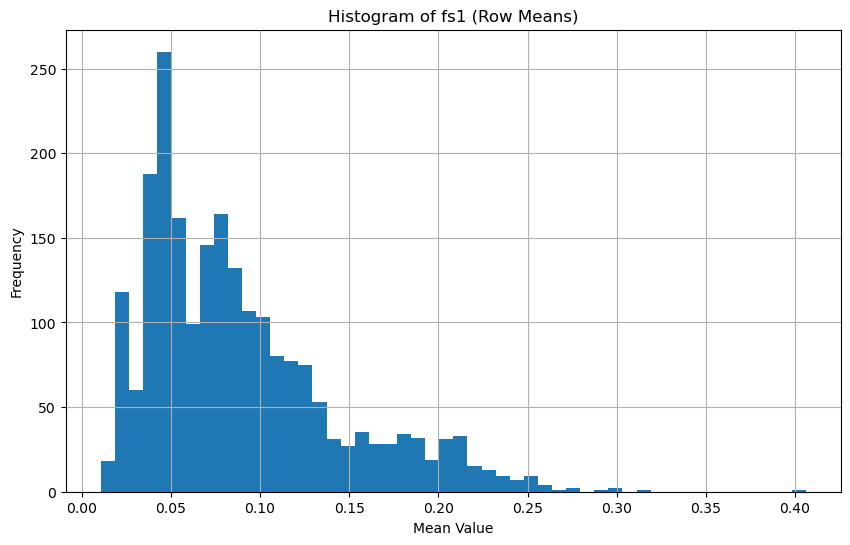

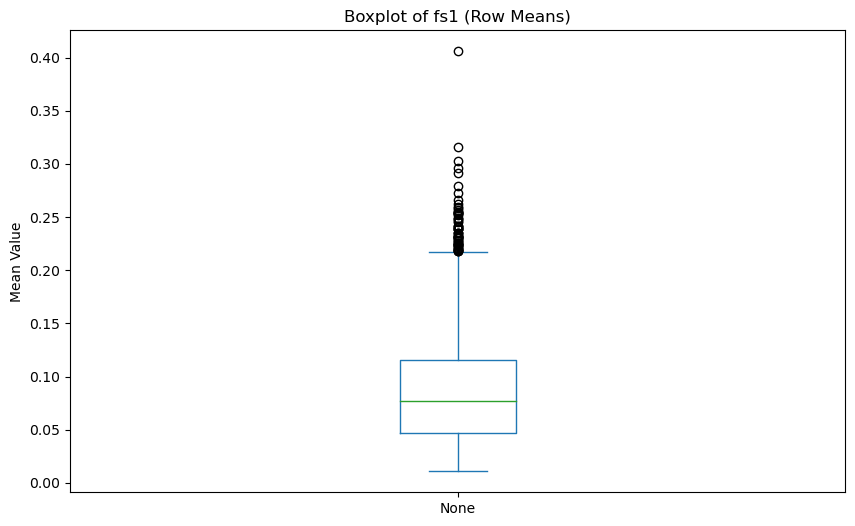

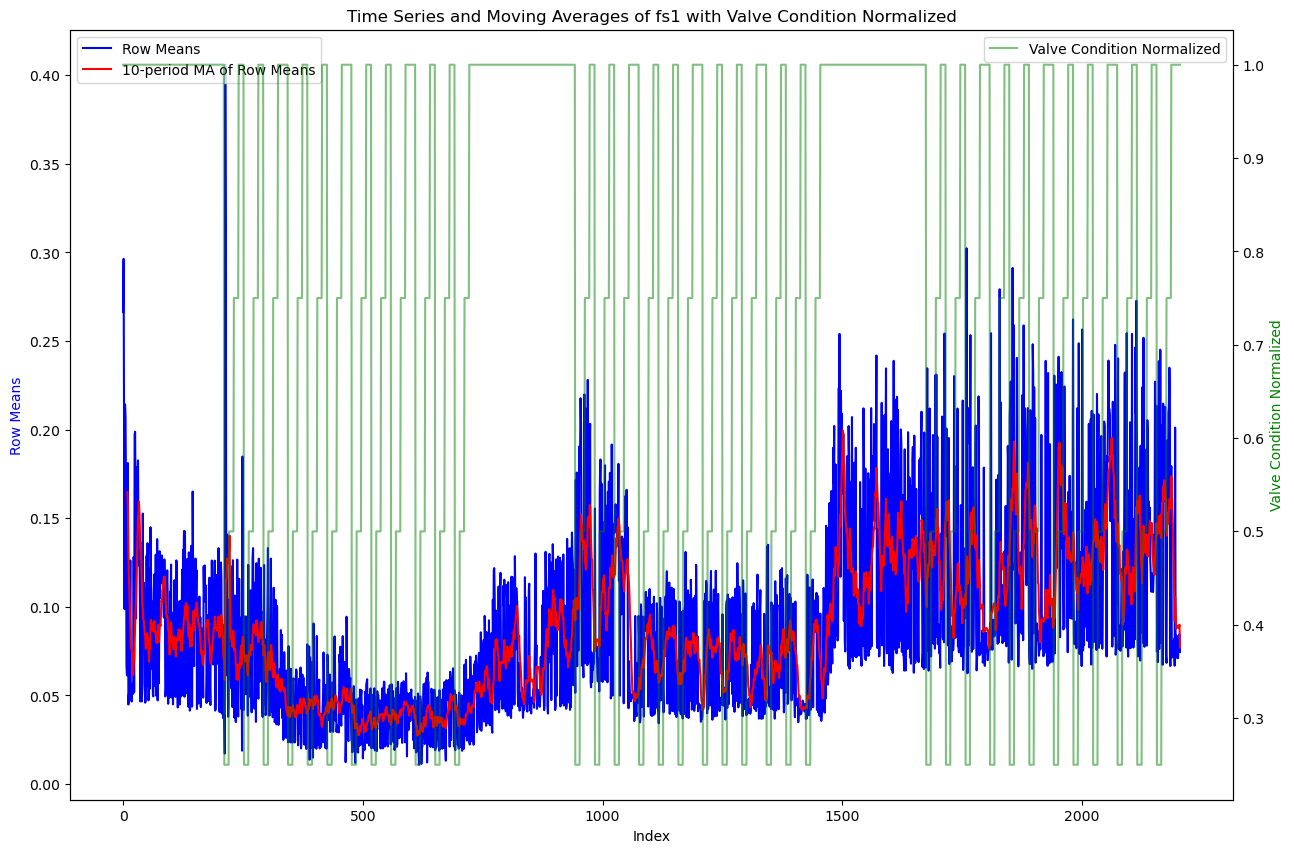

Descriptive Statistics for ps2 (Row Means):
count    2205.000000
mean        0.295641
std         0.115649
min         0.129479
25%         0.230281
50%         0.261195
75%         0.328481
max         0.767154
dtype: float64


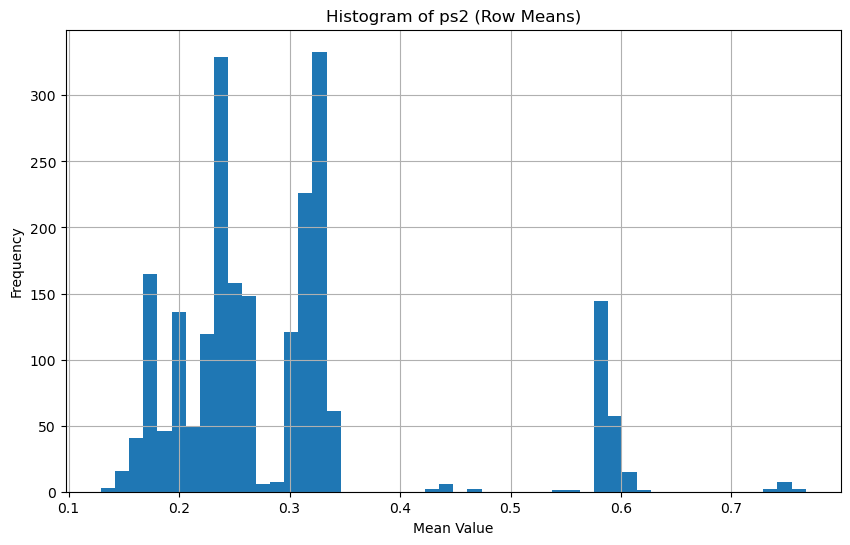

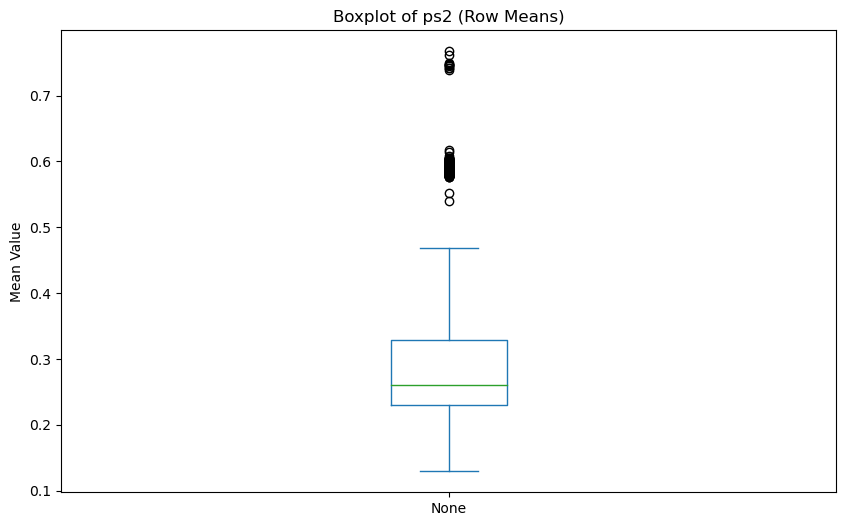

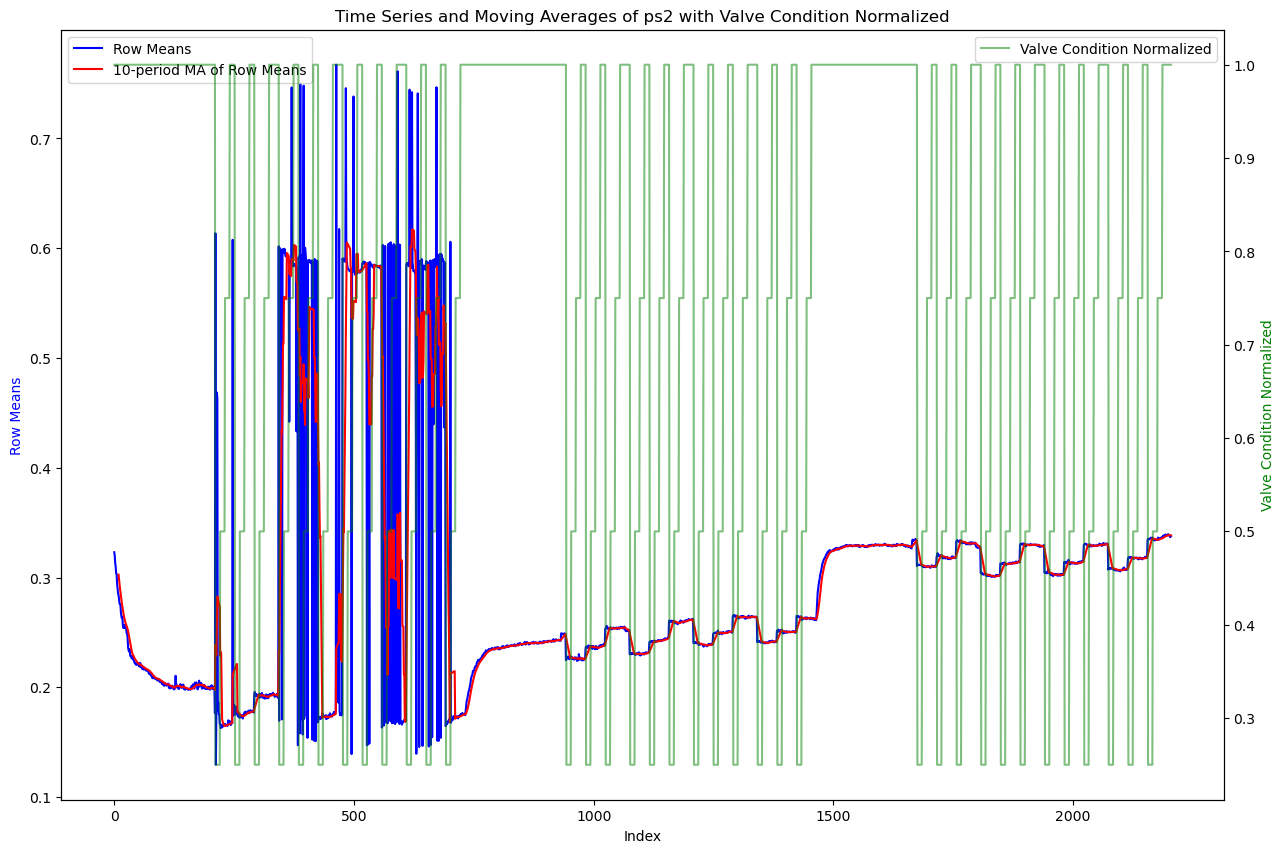

In [76]:
# EDA
def eda_individual(data, name):
    """
    Perform EDA on individual datasets (fs1 and ps2).
    """
    # Calculate mean by row
    row_means = data.mean(axis=1)
    
    # Display descriptive statistics of row means
    print(f"Descriptive Statistics for {name} (Row Means):")
    print(row_means.describe())
    
    # Plot histogram of row means
    plt.figure(figsize=(10, 6))
    row_means.hist(bins=50)
    plt.title(f'Histogram of {name} (Row Means)')
    plt.xlabel('Mean Value')
    plt.ylabel('Frequency')
    plt.show()
    
    # Plot boxplot of row means
    plt.figure(figsize=(10, 6))
    row_means.plot(kind='box')
    plt.title(f'Boxplot of {name} (Row Means)')
    plt.ylabel('Mean Value')
    plt.show()
    
    # Plot time series and moving averages of row means
    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax1.plot(row_means, label='Row Means', color='blue')
    ax1.plot(row_means.rolling(window=10).mean(), label='10-period MA of Row Means', color='red')
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Row Means', color='blue')
    ax1.legend(loc='upper left')

    # Plot valve_condition_normalized in green on the same axis
    ax2 = ax1.twinx()
    ax2.plot(data['valve_condition_normalized'], label='Valve Condition Normalized', color='green', alpha=0.5)
    ax2.set_ylabel('Valve Condition Normalized', color='green')
    ax2.legend(loc='upper right')
    
    plt.title(f'Time Series and Moving Averages of {name} with Valve Condition Normalized')
    plt.show()
    
# Split data into fs1 and ps2
#fs1_data = data.iloc[:, :fs1.shape[1]]
fs1_data = pd.concat([data.iloc[:, :fs1.shape[1]], data[['valve_condition_normalized']]], axis=1)
#ps2_data = data.iloc[:, fs1.shape[1]:fs1.shape[1]+ps2.shape[1]]
ps2_data = pd.concat([data.iloc[:, fs1.shape[1]:fs1.shape[1]+ps2.shape[1]], data[['valve_condition_normalized']]], axis=1)

# Perform EDA on fs1 and ps2
eda_individual(fs1_data, 'fs1')
eda_individual(ps2_data, 'ps2')

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.128406,0.126233,0.139026,0.135629,0.183728,0.926963,0.851924,0.710694,0.525688,0.503085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.118814,0.119439,0.132375,0.128401,0.179034,0.925531,0.847719,0.802688,0.626115,0.599737,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.120340,0.123603,0.135379,0.129464,0.181270,0.928753,0.877821,0.762099,0.577799,0.528001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.115980,0.116809,0.128728,0.122449,0.173670,0.916222,0.851703,0.740890,0.612823,0.592660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.111402,0.111988,0.123150,0.120323,0.173000,0.911210,0.873283,0.789389,0.683976,0.663255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.127752,0.131492,0.145462,0.142219,0.203621,0.987827,0.957614,0.903795,0.767708,0.711449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2201,0.135601,0.133027,0.143102,0.144133,0.208985,0.991407,0.965803,0.915891,0.784219,0.749145,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2202,0.126444,0.128424,0.143961,0.143070,0.204068,0.983889,0.959052,0.893389,0.722059,0.660038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2203,0.137345,0.133684,0.143102,0.143070,0.207197,0.990691,0.964586,0.935194,0.863812,0.845796,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Classifier

In [ ]:
# Define Constants
TRAIN_SIZE = 2000
TARGET_COLUMN = "valve_condition_normalized"
MODEL_PARAMETERS = {
    "LogisticRegression": {"C": [0.001, 0.01, 0.1, 1, 10], "solver": ["liblinear"]},
    "RandomForestClassifier": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
    },
    "GradientBoostingClassifier": {
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5, 7],
    },
    "SVC": {
        "C": [0.01, 0.1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"],
    },
}

In [49]:
class ModelBase:
    def __init__(self, name, model, params):
        self.name = name
        self.model = model
        self.params = params
        self.best_model = None
        self.grid_search = None

    def train(self, X_train, y_train):
        self.grid_search = GridSearchCV(self.model, self.params, cv=5, scoring='accuracy', n_jobs=-1)
        self.grid_search.fit(X_train, y_train)
        self.best_model = self.grid_search.best_estimator_

    def evaluate(self, X_test, y_test):
        y_pred = self.best_model.predict(X_test)
        y_proba = self.best_model.predict_proba(X_test)[:, 1]
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba),
            'precision': precision_score(y_test, y_pred, average='binary'),
            'recall': recall_score(y_test, y_pred, average='binary'),
            'f1_score': f1_score(y_test, y_pred, average='binary'),
            'classification_report': classification_report(y_test, y_pred, output_dict=True)
        }
        return metrics
    
    def predict_cycle(self, cycle_data):
        if self.best_model is None:
            raise ValueError(f"Model {self.name} has not been trained yet.")
        return self.best_model.predict(cycle_data)

class LogisticRegressionModel(ModelBase):
    def __init__(self):
        super().__init__('LogisticRegression', LogisticRegression(), MODEL_PARAMETERS['LogisticRegression'])

class RandomForestClassifierModel(ModelBase):
    def __init__(self):
        super().__init__('RandomForestClassifier', RandomForestClassifier(), MODEL_PARAMETERS['RandomForestClassifier'])

class GradientBoostingClassifierModel(ModelBase):
    def __init__(self):
        super().__init__('GradientBoostingClassifier', GradientBoostingClassifier(), MODEL_PARAMETERS['GradientBoostingClassifier'])

class SVCModel(ModelBase):
    def __init__(self):
        super().__init__('SVC', SVC(probability=True), MODEL_PARAMETERS['SVC'])

In [50]:
def binarize_targets(y, threshold=0.5):
    return (y > threshold).astype(int)

In [51]:
# Split data into train and test
train_data = data.iloc[:TRAIN_SIZE]
test_data = data.iloc[TRAIN_SIZE:]

# Features and target
X_train = train_data.drop(columns=[TARGET_COLUMN])
y_train = train_data[TARGET_COLUMN]
y_train = binarize_targets(y_train)
X_test = test_data.drop(columns=[TARGET_COLUMN])
y_test = test_data[TARGET_COLUMN]
y_test = binarize_targets(y_test)

# Initialize models
models = [
    LogisticRegressionModel(),
    RandomForestClassifierModel(),
    GradientBoostingClassifierModel(),
    SVCModel()
]

In [52]:
%%time
# Train and evaluate models with verbose output
model_results = {}
num_steps = len(models) * 2  # Training and evaluating each model
step_counter = 0

for model in models:
    step_counter += 1
    print(f"Step {step_counter}/{num_steps}: Training {model.name}...")
    model.train(X_train, y_train)
    step_counter += 1
    print(f"Step {step_counter}/{num_steps}: Evaluating {model.name}...")
    metrics = model.evaluate(X_test, y_test)
    model_results[model.name] = metrics

Step 1/8: Training LogisticRegression...


/Users/baptiste/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/baptiste/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/baptiste/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/baptiste/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  

Step 2/8: Evaluating LogisticRegression...
Step 3/8: Training RandomForestClassifier...
Step 4/8: Evaluating RandomForestClassifier...
Step 5/8: Training GradientBoostingClassifier...
Step 6/8: Evaluating GradientBoostingClassifier...
Step 7/8: Training SVC...
Step 8/8: Evaluating SVC...
CPU times: user 52.7 s, sys: 1.65 s, total: 54.3 s
Wall time: 3min 38s



LogisticRegression Results:
Accuracy: 1.0
ROC AUC: 1.0
Classification Report: {'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 444}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 761}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1205}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1205}}

RandomForestClassifier Results:
Accuracy: 1.0
ROC AUC: 1.0
Classification Report: {'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 444}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 761}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1205}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1205}}

GradientBoostingClassifier Results:
Accuracy: 1.0
ROC AUC: 1.0
Classification Report: {'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 444}, '1': {'precisio

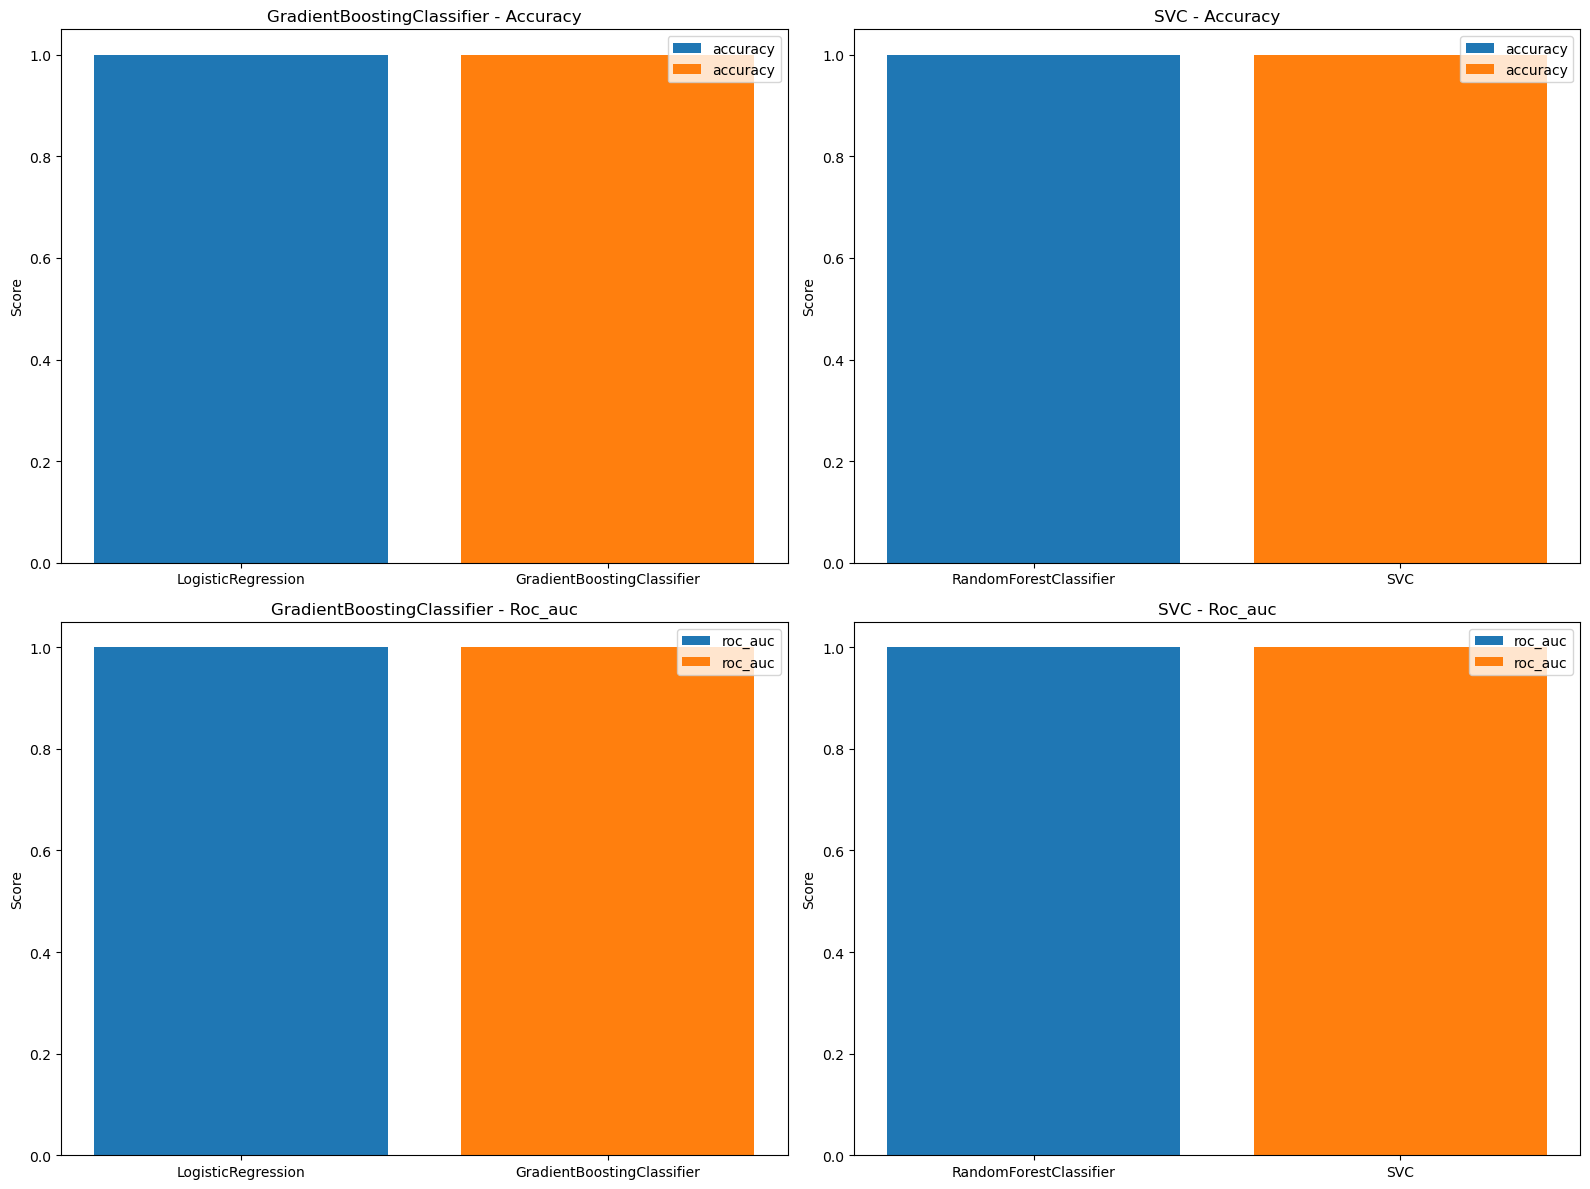

In [45]:
# Print results
for model_name, results in model_results.items():
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {results['accuracy']}")
    print(f"ROC AUC: {results['roc_auc']}")
    print(f"Classification Report: {results['classification_report']}")

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
model_names = list(model_results.keys())
metrics_names = ['accuracy', 'roc_auc']

for i, metric in enumerate(metrics_names):
    for j, model_name in enumerate(model_names):
        axs[i, j % 2].bar(model_name, model_results[model_name][metric], label=metric)
        axs[i, j % 2].set_title(f"{model_name} - {metric.capitalize()}")
        axs[i, j % 2].set_ylabel('Score')
        axs[i, j % 2].legend()

plt.tight_layout()
plt.show()

In [46]:
model_results

{'LogisticRegression': {'accuracy': 1.0,
  'roc_auc': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1_score': 1.0,
  'classification_report': {'0': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 444},
   '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 761},
   'accuracy': 1.0,
   'macro avg': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 1205},
   'weighted avg': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 1205}}},
 'RandomForestClassifier': {'accuracy': 1.0,
  'roc_auc': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1_score': 1.0,
  'classification_report': {'0': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 444},
   '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 761},
   'accuracy': 1.0,
   'macro avg': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 1205},
   'weighted avg': {'precision': 1.0,
    'recall': 

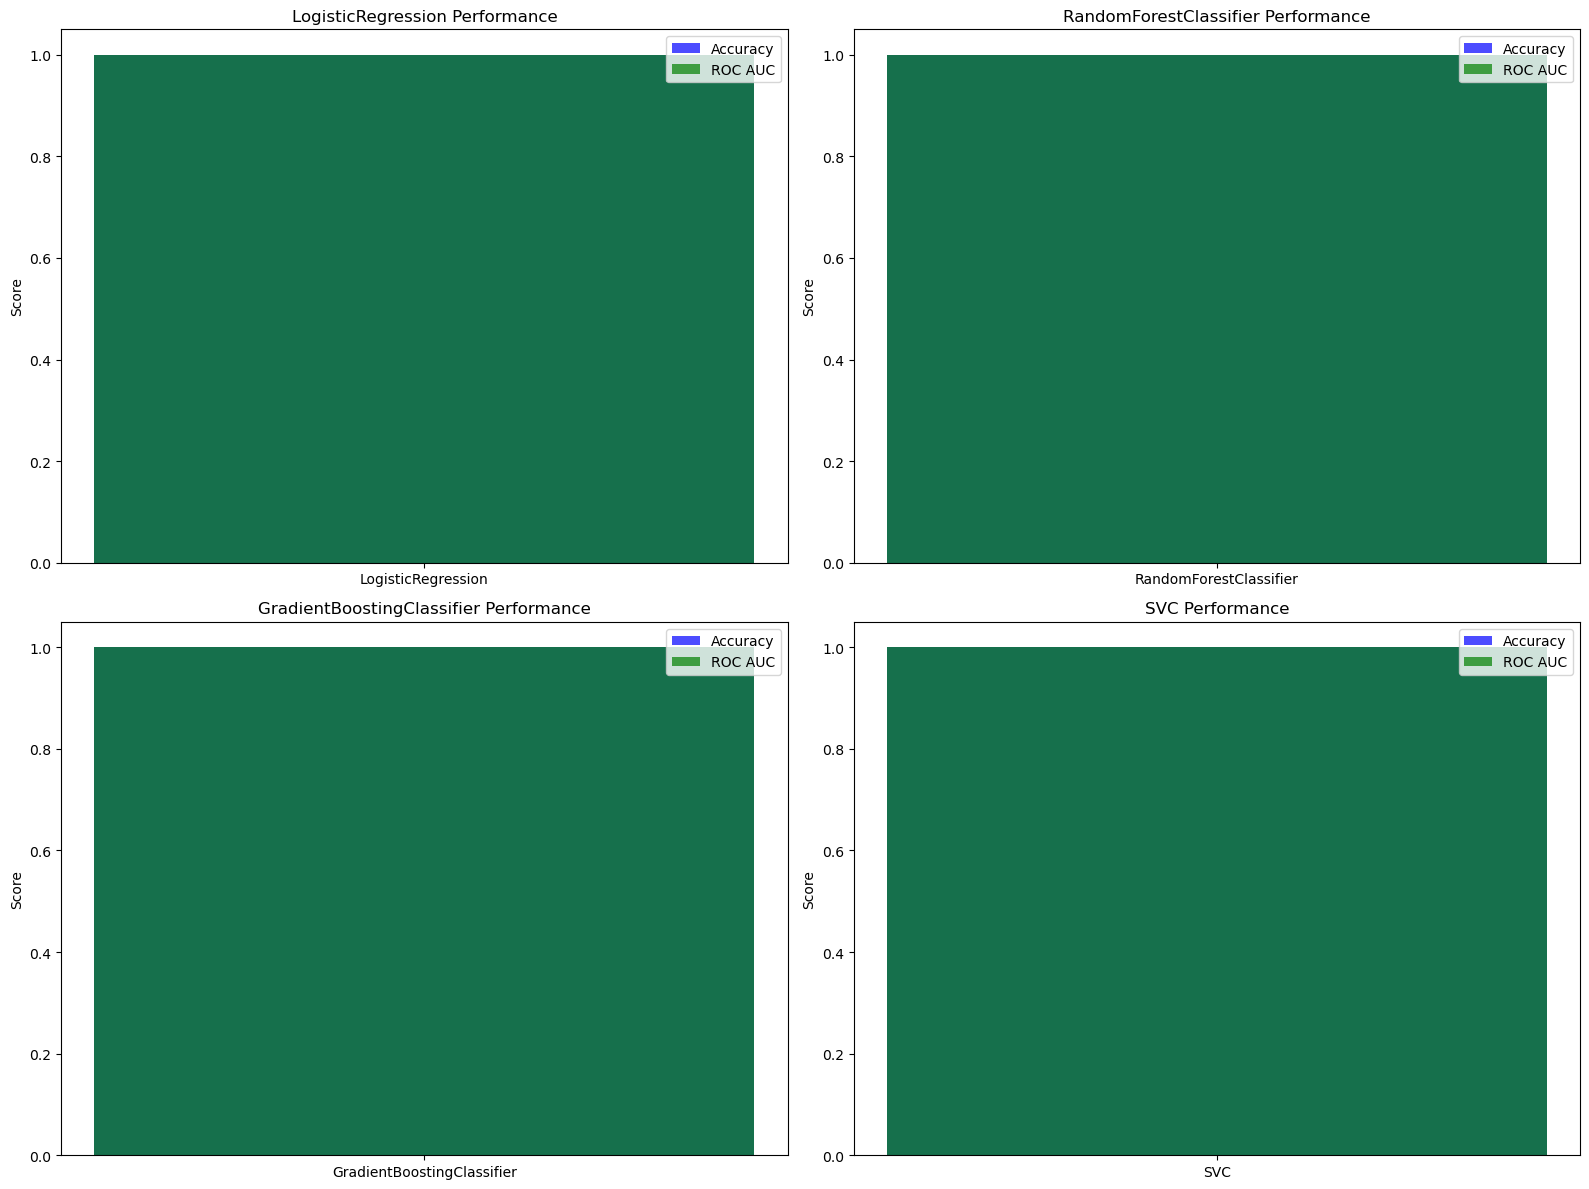

In [47]:
# Plot metrics
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

for i, (model_name, results) in enumerate(model_results.items()):
    row, col = divmod(i, 2)
    
    # Plot accuracy and ROC AUC
    axs[row, col].bar(model_name, results['accuracy'], color='blue', alpha=0.7, label='Accuracy')
    axs[row, col].bar(model_name, results['roc_auc'], color='green', alpha=0.7, label='ROC AUC')
    
    axs[row, col].set_title(f"{model_name} Performance")
    axs[row, col].set_ylabel("Score")
    axs[row, col].legend()

plt.tight_layout()
plt.show()

### Inference

In [81]:
# Method to predict the condition for a given cycle number
def predict_condition_for_cycle(cycle_number, model_name):
    # Load the cycle data
    #cycle_data = data[data['cycle_number'] == cycle_number].drop(columns=[TARGET_COLUMN, 'cycle_number'])
    cycle_data = data.iloc[[cycle_number]].drop(columns=[TARGET_COLUMN])
    
    if cycle_data.empty:
        raise ValueError(f"No data found for cycle number {cycle_number}")
    
    # Select the model
    selected_model = next((model for model in models if model.name == model_name), None)
    
    if selected_model is None:
        raise ValueError(f"Model {model_name} not found")
    
    # Predict the condition
    prediction = selected_model.predict_cycle(cycle_data)
    
    return prediction

# Example usage
cycle_number = 110
model_name = 'RandomForestClassifier'
prediction = predict_condition_for_cycle(cycle_number, model_name)
print(f"The predicted condition for cycle number {cycle_number} using {model_name} is: {prediction}")

The predicted condition for cycle number 110 using RandomForestClassifier is: [1]
